In [1]:
import os
import sys

base_directory = "../"
sys.path.insert(0, base_directory)
print(os.path.abspath(base_directory))

import json
import torch
import configparser
import safetensors as st
from stable_diffusion import StableDiffusion
from stable_diffusion.model.clip_text_embedder import CLIPTextEmbedder
from stable_diffusion.utils.model import *
from stable_diffusion.utils.utils import get_device, to_pil, get_memory_status
from stable_diffusion.utils.model import initialize_latent_diffusion
from stable_diffusion.constants import IODirectoryTree, create_directory_tree_paths
from stable_diffusion.constants import TOKENIZER_PATH, TEXT_MODEL_PATH
from transformers import CLIPTextModel, CLIPTokenizer


/home/izzortsi/.cloned/kcg-ml-sd1p4


In [2]:
DEVICE = get_device()
config = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
config.read(os.path.join(base_directory, "config.ini"))
config['BASE']['BASE_DIRECTORY'] = base_directory

INFO: `device` given is `None`. Falling back to device: cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [3]:
config["BASE"].get('base_io_directory')

'../io'

In [4]:
config["BASE"].get('base_io_directory_prefix'), base_directory

('io', '../')

In [5]:
pt = IODirectoryTree(base_io_directory_prefix = config["BASE"].get('base_io_directory_prefix'), base_directory=base_directory)
pt

IODirectoryTree:
                - ../io
                -- model's root dir: ../io/input/model/
                --- stable diffusion model checkpoint: ../io/input/model/v1-5-pruned-emaonly.safetensors
                --- stable diffusion submodels dir: ../io/input/model/v1-5-pruned-emaonly
                ---- unet model: ../io/input/model/v1-5-pruned-emaonly/unet.safetensors
                ---- autoencoder model: ../io/input/model/v1-5-pruned-emaonly/autoencoder.safetensors
                ---- encoder model: ../io/input/model/v1-5-pruned-emaonly/encoder.safetensors
                ---- decoder model: ../io/input/model/v1-5-pruned-emaonly/decoder.safetensors
                ---- latent_diffusion model: ../io/input/model/v1-5-pruned-emaonly/latent_diffusion.safetensors
                --- clip models' root dir: ../io/input/model/clip
                ---- clip image encoder checkpoint path: ../io/input/model/clip/image_encoder.safetensors
                ---- clip text embedder checkp

In [6]:
os.path.abspath(pt.root_models_dir), pt.root_models_dir

('/home/izzortsi/.cloned/kcg-ml-sd1p4/io/input/model', '../io/input/model/')

In [7]:
pt.create_directory_tree_folders()

{'root_models_path': './io/input/model/',
 'checkpoint_path': './io/input/model/v1-5-pruned-emaonly.safetensors',
 'embedder_path': './io/input/model/clip/text_embedder.safetensors',
 'embedder_submodels_paths': {'tokenizer_path': './io/input/model/clip/text_embedder/tokenizer',
  'transformer_path': './io/input/model/clip/text_embedder/vit-large-patch14'},
 'image_encoder_path': './io/input/model/clip/image_encoder/clip_image_encoder.ckpt',
 'image_encoder_submodels_paths': {'image_processor_path': './io/input/model/clip/image_encoder/image_processor.ckpt',
  'clip_model_path': './io/input/model/clip/image_encoder/clip_model.ckpt'},
 'unet_path': './io/input/model/v1-5-pruned-emaonly/unet.safetensors',
 'autoencoder_path': './io/input/model/v1-5-pruned-emaonly/autoencoder.safetensors',
 'autoencoder_submodels_paths': {'encoder_path': './io/input/model/v1-5-pruned-emaonly/encoder.safetensors',
  'decoder_path': './io/input/model/v1-5-pruned-emaonly/decoder.safetensors'},
 'latent_diffu

In [8]:
tokenizer = CLIPTokenizer.from_pretrained(pt.tokenizer_path, local_files_only=True)

In [9]:
sd_savepath = os.path.join(pt.sd_model_dir, "clip_")
tokenizer.save_pretrained(sd_savepath+"tokenizer", safe_serialization=True)

('../io/input/model/v1-5-pruned-emaonly/clip_tokenizer/tokenizer_config.json',
 '../io/input/model/v1-5-pruned-emaonly/clip_tokenizer/special_tokens_map.json',
 '../io/input/model/v1-5-pruned-emaonly/clip_tokenizer/vocab.json',
 '../io/input/model/v1-5-pruned-emaonly/clip_tokenizer/merges.txt',
 '../io/input/model/v1-5-pruned-emaonly/clip_tokenizer/added_tokens.json')

In [10]:
pt.text_model_path

'../io/input/model/clip/text_embedder/vit-large-patch14'

In [11]:
text_model = CLIPTextModel.from_pretrained(pt.text_model_path, local_files_only=True, use_safetensors=True).eval().to(DEVICE)

In [12]:
text_model.save_pretrained(sd_savepath+"text_model", safe_serialization=True)

In [13]:
text_model = CLIPTextModel.from_pretrained(sd_savepath+"text_model", local_files_only=True, use_safetensors=True)

In [14]:
text_embedder = CLIPTextEmbedder(pt, device=DEVICE, tokenizer = tokenizer, text_model=text_model)

INFO: Device given: cuda:0. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [15]:
text_embedder.to(text_embedder.device)

CLIPTextEmbedder(
  (text_model): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, 

In [16]:
text_embedder('A great sword')

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [-1.0926, -1.1347,  1.7090,  ..., -1.5931, -1.3204, -0.3113],
         ...,
         [-1.1672, -0.2287,  0.3293,  ..., -0.9333, -1.6369, -0.9976],
         [-1.1720, -0.2120,  0.3480,  ..., -0.9284, -1.6393, -0.9869],
         [-1.1639, -0.1673,  0.3849,  ..., -0.9276, -1.6307, -1.0183]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [18]:
text_embedder.save_submodels(tokenizer_path=pt.tokenizer_path, text_model_path=pt.text_model_path)

tokenizer saved to:  ../io/input/model/clip/text_embedder/tokenizer
text_model saved to:  ../io/input/model/clip/text_embedder/vit-large-patch14


In [16]:
pt.text_embedder_path, TEXT_EMBEDDER_PATH

('../io/input/model/clip/text_embedder.safetensors',
 './io/input/model/clip/text_embedder.safetensors')

In [19]:
st.torch.save_model(text_embedder, pt.text_embedder_path)

In [21]:
loaded = st.torch.load_model(CLIPTextEmbedder(), pt.text_embedder_path)

INFO: `device` given is `None`. Falling back to device: cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


RuntimeError: Error(s) in loading state_dict for CLIPTextEmbedder:
    Unexpected key(s) in state_dict: "text_model.text_model.embeddings.position_embedding.weight", "text_model.text_model.embeddings.position_ids", "text_model.text_model.embeddings.token_embedding.weight", "text_model.text_model.encoder.layers.0.layer_norm1.bias", "text_model.text_model.encoder.layers.0.layer_norm1.weight", "text_model.text_model.encoder.layers.0.layer_norm2.bias", "text_model.text_model.encoder.layers.0.layer_norm2.weight", "text_model.text_model.encoder.layers.0.mlp.fc1.bias", "text_model.text_model.encoder.layers.0.mlp.fc1.weight", "text_model.text_model.encoder.layers.0.mlp.fc2.bias", "text_model.text_model.encoder.layers.0.mlp.fc2.weight", "text_model.text_model.encoder.layers.0.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.0.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.0.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.0.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.0.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.0.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.0.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.0.self_attn.v_proj.weight", "text_model.text_model.encoder.layers.1.layer_norm1.bias", "text_model.text_model.encoder.layers.1.layer_norm1.weight", "text_model.text_model.encoder.layers.1.layer_norm2.bias", "text_model.text_model.encoder.layers.1.layer_norm2.weight", "text_model.text_model.encoder.layers.1.mlp.fc1.bias", "text_model.text_model.encoder.layers.1.mlp.fc1.weight", "text_model.text_model.encoder.layers.1.mlp.fc2.bias", "text_model.text_model.encoder.layers.1.mlp.fc2.weight", "text_model.text_model.encoder.layers.1.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.1.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.1.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.1.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.1.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.1.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.1.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.1.self_attn.v_proj.weight", "text_model.text_model.encoder.layers.10.layer_norm1.bias", "text_model.text_model.encoder.layers.10.layer_norm1.weight", "text_model.text_model.encoder.layers.10.layer_norm2.bias", "text_model.text_model.encoder.layers.10.layer_norm2.weight", "text_model.text_model.encoder.layers.10.mlp.fc1.bias", "text_model.text_model.encoder.layers.10.mlp.fc1.weight", "text_model.text_model.encoder.layers.10.mlp.fc2.bias", "text_model.text_model.encoder.layers.10.mlp.fc2.weight", "text_model.text_model.encoder.layers.10.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.10.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.10.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.10.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.10.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.10.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.10.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.10.self_attn.v_proj.weight", "text_model.text_model.encoder.layers.11.layer_norm1.bias", "text_model.text_model.encoder.layers.11.layer_norm1.weight", "text_model.text_model.encoder.layers.11.layer_norm2.bias", "text_model.text_model.encoder.layers.11.layer_norm2.weight", "text_model.text_model.encoder.layers.11.mlp.fc1.bias", "text_model.text_model.encoder.layers.11.mlp.fc1.weight", "text_model.text_model.encoder.layers.11.mlp.fc2.bias", "text_model.text_model.encoder.layers.11.mlp.fc2.weight", "text_model.text_model.encoder.layers.11.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.11.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.11.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.11.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.11.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.11.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.11.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.11.self_attn.v_proj.weight", "text_model.text_model.encoder.layers.2.layer_norm1.bias", "text_model.text_model.encoder.layers.2.layer_norm1.weight", "text_model.text_model.encoder.layers.2.layer_norm2.bias", "text_model.text_model.encoder.layers.2.layer_norm2.weight", "text_model.text_model.encoder.layers.2.mlp.fc1.bias", "text_model.text_model.encoder.layers.2.mlp.fc1.weight", "text_model.text_model.encoder.layers.2.mlp.fc2.bias", "text_model.text_model.encoder.layers.2.mlp.fc2.weight", "text_model.text_model.encoder.layers.2.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.2.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.2.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.2.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.2.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.2.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.2.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.2.self_attn.v_proj.weight", "text_model.text_model.encoder.layers.3.layer_norm1.bias", "text_model.text_model.encoder.layers.3.layer_norm1.weight", "text_model.text_model.encoder.layers.3.layer_norm2.bias", "text_model.text_model.encoder.layers.3.layer_norm2.weight", "text_model.text_model.encoder.layers.3.mlp.fc1.bias", "text_model.text_model.encoder.layers.3.mlp.fc1.weight", "text_model.text_model.encoder.layers.3.mlp.fc2.bias", "text_model.text_model.encoder.layers.3.mlp.fc2.weight", "text_model.text_model.encoder.layers.3.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.3.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.3.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.3.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.3.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.3.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.3.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.3.self_attn.v_proj.weight", "text_model.text_model.encoder.layers.4.layer_norm1.bias", "text_model.text_model.encoder.layers.4.layer_norm1.weight", "text_model.text_model.encoder.layers.4.layer_norm2.bias", "text_model.text_model.encoder.layers.4.layer_norm2.weight", "text_model.text_model.encoder.layers.4.mlp.fc1.bias", "text_model.text_model.encoder.layers.4.mlp.fc1.weight", "text_model.text_model.encoder.layers.4.mlp.fc2.bias", "text_model.text_model.encoder.layers.4.mlp.fc2.weight", "text_model.text_model.encoder.layers.4.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.4.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.4.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.4.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.4.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.4.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.4.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.4.self_attn.v_proj.weight", "text_model.text_model.encoder.layers.5.layer_norm1.bias", "text_model.text_model.encoder.layers.5.layer_norm1.weight", "text_model.text_model.encoder.layers.5.layer_norm2.bias", "text_model.text_model.encoder.layers.5.layer_norm2.weight", "text_model.text_model.encoder.layers.5.mlp.fc1.bias", "text_model.text_model.encoder.layers.5.mlp.fc1.weight", "text_model.text_model.encoder.layers.5.mlp.fc2.bias", "text_model.text_model.encoder.layers.5.mlp.fc2.weight", "text_model.text_model.encoder.layers.5.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.5.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.5.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.5.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.5.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.5.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.5.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.5.self_attn.v_proj.weight", "text_model.text_model.encoder.layers.6.layer_norm1.bias", "text_model.text_model.encoder.layers.6.layer_norm1.weight", "text_model.text_model.encoder.layers.6.layer_norm2.bias", "text_model.text_model.encoder.layers.6.layer_norm2.weight", "text_model.text_model.encoder.layers.6.mlp.fc1.bias", "text_model.text_model.encoder.layers.6.mlp.fc1.weight", "text_model.text_model.encoder.layers.6.mlp.fc2.bias", "text_model.text_model.encoder.layers.6.mlp.fc2.weight", "text_model.text_model.encoder.layers.6.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.6.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.6.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.6.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.6.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.6.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.6.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.6.self_attn.v_proj.weight", "text_model.text_model.encoder.layers.7.layer_norm1.bias", "text_model.text_model.encoder.layers.7.layer_norm1.weight", "text_model.text_model.encoder.layers.7.layer_norm2.bias", "text_model.text_model.encoder.layers.7.layer_norm2.weight", "text_model.text_model.encoder.layers.7.mlp.fc1.bias", "text_model.text_model.encoder.layers.7.mlp.fc1.weight", "text_model.text_model.encoder.layers.7.mlp.fc2.bias", "text_model.text_model.encoder.layers.7.mlp.fc2.weight", "text_model.text_model.encoder.layers.7.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.7.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.7.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.7.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.7.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.7.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.7.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.7.self_attn.v_proj.weight", "text_model.text_model.encoder.layers.8.layer_norm1.bias", "text_model.text_model.encoder.layers.8.layer_norm1.weight", "text_model.text_model.encoder.layers.8.layer_norm2.bias", "text_model.text_model.encoder.layers.8.layer_norm2.weight", "text_model.text_model.encoder.layers.8.mlp.fc1.bias", "text_model.text_model.encoder.layers.8.mlp.fc1.weight", "text_model.text_model.encoder.layers.8.mlp.fc2.bias", "text_model.text_model.encoder.layers.8.mlp.fc2.weight", "text_model.text_model.encoder.layers.8.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.8.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.8.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.8.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.8.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.8.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.8.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.8.self_attn.v_proj.weight", "text_model.text_model.encoder.layers.9.layer_norm1.bias", "text_model.text_model.encoder.layers.9.layer_norm1.weight", "text_model.text_model.encoder.layers.9.layer_norm2.bias", "text_model.text_model.encoder.layers.9.layer_norm2.weight", "text_model.text_model.encoder.layers.9.mlp.fc1.bias", "text_model.text_model.encoder.layers.9.mlp.fc1.weight", "text_model.text_model.encoder.layers.9.mlp.fc2.bias", "text_model.text_model.encoder.layers.9.mlp.fc2.weight", "text_model.text_model.encoder.layers.9.self_attn.k_proj.bias", "text_model.text_model.encoder.layers.9.self_attn.k_proj.weight", "text_model.text_model.encoder.layers.9.self_attn.out_proj.bias", "text_model.text_model.encoder.layers.9.self_attn.out_proj.weight", "text_model.text_model.encoder.layers.9.self_attn.q_proj.bias", "text_model.text_model.encoder.layers.9.self_attn.q_proj.weight", "text_model.text_model.encoder.layers.9.self_attn.v_proj.bias", "text_model.text_model.encoder.layers.9.self_attn.v_proj.weight", "text_model.text_model.final_layer_norm.bias", "text_model.text_model.final_layer_norm.weight"

In [12]:
text_embedder("A painting of a computer virus")

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [-0.1969,  0.2920,  1.3066,  ..., -1.9838, -1.2365,  1.7627],
         ...,
         [-0.3803,  0.1243, -0.6604,  ...,  0.1959, -0.7981, -0.5288],
         [-0.3792,  0.1261, -0.6617,  ...,  0.1989, -0.7840, -0.5277],
         [-0.3744,  0.2052, -0.6593,  ...,  0.1867, -0.7819, -0.4871]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [13]:
text_embedder_ = CLIPTextEmbedder(pt, device=None)

INFO: `device` is None. Using device  cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [15]:
state_dict = st.torch.load_file(TEXT_EMBEDDER_PATH)

In [17]:
text_embedder_.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['text_model.text_model.embeddings.position_embedding.weight', 'text_model.text_model.embeddings.position_ids', 'text_model.text_model.embeddings.token_embedding.weight', 'text_model.text_model.encoder.layers.0.layer_norm1.bias', 'text_model.text_model.encoder.layers.0.layer_norm1.weight', 'text_model.text_model.encoder.layers.0.layer_norm2.bias', 'text_model.text_model.encoder.layers.0.layer_norm2.weight', 'text_model.text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.text_model.encoder.layers.0.self_attn.out_proj.bias', 'text_model.text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.text_model.encoder.layers.0.self_attn.

In [19]:
text_embedder

CLIPTextEmbedder(
  (text_model): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, 

In [12]:
ld = initialize_latent_diffusion(pt.checkpoint_path, device=DEVICE, clip_text_embedder=text_embedder, force_submodels_init=True)

INFO: Device given. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


HTML(value='<pre  style="overflow-x: scroll;">autoencoder initialization...</pre>')

INFO: Device given. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: Device given. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: Device given. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: `device` is None. Using device  cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: Device given. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: `device` is None. Using device  cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [13]:
stable_diffusion = StableDiffusion(device=DEVICE, model = ld, ddim_steps = 20)

INFO: Device given. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
LatentDiffusion model given. Initializing sampler.


In [14]:
type(stable_diffusion.sampler)

stable_diffusion.sampler.ddim.DDIMSampler

In [15]:
img = stable_diffusion.generate_images(prompt = 'A greenish smiling salsage')

HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

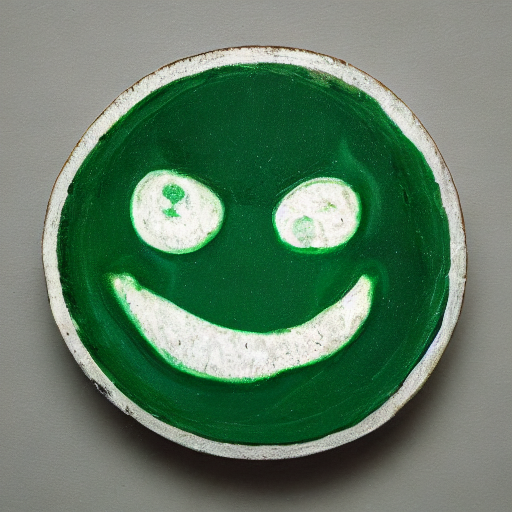

In [ ]:
to_pil(img.squeeze())

In [ ]:
stable_diffusion.model.autoencoder.save_submodels(**pt.autoencoder_submodels)
stable_diffusion.model.autoencoder.unload_submodels()
stable_diffusion.model.autoencoder.save(**pt.autoencoder)

Encoder saved to: E:\ML\input/models/v1-5-pruned-emaonly\encoder.safetensors
Decoder saved to: E:\ML\input/models/v1-5-pruned-emaonly\decoder.safetensors
Autoencoder saved to: E:\ML\input/models/v1-5-pruned-emaonly\autoencoder.safetensors


In [ ]:
stable_diffusion.model.unet.diffusion_model.save(**pt.unet)

Autoencoder saved to: E:\ML\input/models/v1-5-pruned-emaonly\unet.safetensors


In [ ]:
stable_diffusion.model.unload_unet()
get_memory_status()

Total: 12287 MiB
Free: 9336 MiB
Used: 2951 MiB


In [11]:
stable_diffusion.model.clip_embedder.save(**pt.embedder)

CLIPTextEmbedder saved to: E:\ML\input/models/v1-5-pruned-emaonly\clip_text_embedder.safetensors


In [12]:
stable_diffusion.model.unload_clip_embedder()
get_memory_status()

Total: 12287 MiB
Free: 9864 MiB
Used: 2423 MiB


In [13]:
from stable_diffusion.model.clip_text_embedder import CLIPTextEmbedder

In [14]:
text_embedder = CLIPTextEmbedder(device=DEVICE)

INFO: Device given. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [16]:
text_embedder_state_dict = st.torch.load_file(pt.embedder_path)

In [17]:
text_embedder.load_state_dict(text_embedder_state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['transformer.text_model.embeddings.position_embedding.weight', 'transformer.text_model.embeddings.position_ids', 'transformer.text_model.embeddings.token_embedding.weight', 'transformer.text_model.encoder.layers.0.layer_norm1.bias', 'transformer.text_model.encoder.layers.0.layer_norm1.weight', 'transformer.text_model.encoder.layers.0.layer_norm2.bias', 'transformer.text_model.encoder.layers.0.layer_norm2.weight', 'transformer.text_model.encoder.layers.0.mlp.fc1.bias', 'transformer.text_model.encoder.layers.0.mlp.fc1.weight', 'transformer.text_model.encoder.layers.0.mlp.fc2.bias', 'transformer.text_model.encoder.layers.0.mlp.fc2.weight', 'transformer.text_model.encoder.layers.0.self_attn.k_proj.bias', 'transformer.text_model.encoder.layers.0.self_attn.k_proj.weight', 'transformer.text_model.encoder.layers.0.self_attn.out_proj.bias', 'transformer.text_model.encoder.layers.0.self_attn.out_proj.weight', 'transformer.text_model.encoder.lay

In [17]:
encoder = initialize_encoder(device=DEVICE)
ld.autoencoder = initialize_autoencoder(device=DEVICE)

INFO: Device given. Using device cpu.
CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.
INFO: Device given. Using device cpu.
CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.
INFO: `device` is None. Using device  cpu.
CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.


In [22]:
vae = initialize_autoencoder(device=DEVICE, force_submodels_init=True)

INFO: Device given. Using device cpu.
CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.
INFO: Device given. Using device cpu.
CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.
INFO: Device given. Using device cpu.
CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.
INFO: `device` is None. Using device  cpu.
CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.


In [23]:
vae

Autoencoder(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nin_shortcut): Identity()
          )
        )
        (downsample): DownSample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 256, eps=1e-06, affine=Tr

In [7]:
device = get_device()
stable_diffusion = StableDiffusion(
        device=device
    )
stable_diffusion.quick_initialize()

INFO: `device` is None. Using device  cpu.
CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.
INFO: Device given. Using device cpu.
CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.
INFO: Device given. Using device cpu.
CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.


LatentDiffusion(
  (model): UNetWrapper()
)

In [6]:
# from stable_diffusion.model.clip_text_embedder.clip_text_embedder import CLIPTextEmbedder
from typing import List

from torch import nn
from transformers import CLIPTokenizer, CLIPTextModel


class CLIPTextEmbedder(nn.Module):
    """
    ## CLIP Text Embedder
    """

    def __init__(self, text_model_path, tokenizer_path, device="cuda:0", max_length: int = 77):
        """
        :param version: is the model version
        :param device: is the device
        :param max_length: is the max length of the tokenized prompt
        """
        super().__init__()
        self.device = get_device(device)
        # Load the tokenizer
        self.tokenizer = None
        # Load the CLIP transformer
        self.transformer = None

        self.max_length = max_length
        self.to(self.device)
    
    def forward(self, prompts: List[str]):
        """
        :param prompts: are the list of prompts to embed
        """
        # Tokenize the prompts
        batch_encoding = self.tokenizer(prompts, truncation=True, max_length=self.max_length, return_length=True,
                                        return_overflowing_tokens=False, padding="max_length", return_tensors="pt")
        # Get token ids
        tokens = batch_encoding["input_ids"].to(self.device)
        # Get CLIP embeddings
        return self.transformer(input_ids=tokens).last_hidden_state

In [8]:
# text_embedder = CLIPTextEmbedder(pt.embedder_path, pt.tokenizer_path, device=)
text_model = CLIPTextModel.from_pretrained(pt.transformer_path).eval().to(device)

OSError: It looks like the config file at '/home/izzortsi/.cloned/kcg-ml-sd1p4/input/models/clip/text_embedder.safetensors' is not a valid JSON file.

In [8]:
model = load_model(stable_diffusion.model, pt.checkpoint_path, strict=False)

NameError: name 'load_model' is not defined

In [13]:
model[1]

['alphas_cumprod',
 'alphas_cumprod_prev',
 'betas',
 'cond_stage_model.transformer.text_model.embeddings.position_embedding.weight',
 'cond_stage_model.transformer.text_model.embeddings.position_ids',
 'cond_stage_model.transformer.text_model.embeddings.token_embedding.weight',
 'cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.bias',
 'cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.weight',
 'cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.bias',
 'cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.weight',
 'cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.bias',
 'cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.weight',
 'cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.bias',
 'cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.weight',
 'cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.bias',
 'cond_stage_model.tr

In [6]:
stable_diffusion.generate_images(prompt="A cat digging a hole")

TypeError: 'NoneType' object is not callable

In [4]:
def init_stable_diffusion(device, pt, sampler_name="ddim", n_steps=20, ddim_eta=0.0):
    device = get_device(device)

    stable_diffusion = StableDiffusion(
        device=device, sampler_name=sampler_name, n_steps=n_steps, ddim_eta=ddim_eta
    )

    stable_diffusion.quick_initialize()
    stable_diffusion.model.load_unet(**pt.unet)
    stable_diffusion.model.load_autoencoder(**pt.autoencoder).load_decoder(**pt.decoder)

    return stable_diffusion

In [5]:
sd = init_stable_diffusion("cuda", pt, n_steps=20)

INFO: Device given. Using device cuda.
INFO: Using CUDA device None: NVIDIA GeForce RTX 3080 Ti.
INFO: Device given. Using device cuda.
INFO: Using CUDA device None: NVIDIA GeForce RTX 3080 Ti.
INFO: Device given. Using device cuda.
INFO: Using CUDA device None: NVIDIA GeForce RTX 3080 Ti.
Autoencoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\autoencoder.ckpt
Decoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\decoder.ckpt


In [6]:
sd.model.load_state_dict(tensors)

RuntimeError: Error(s) in loading state_dict for LatentDiffusion:
	Missing key(s) in state_dict: "beta", "alpha_bar". 
	Unexpected key(s) in state_dict: "alphas_cumprod", "alphas_cumprod_prev", "betas", "cond_stage_model.transformer.text_model.embeddings.position_embedding.weight", "cond_stage_model.transformer.text_model.embeddings.position_ids", "cond_stage_model.transformer.text_model.embeddings.token_embedding.weight", "cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.bias", "cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.weight", "cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.bias", "cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.weight", "cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.bias", "cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.weight", "cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.bias", "cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.weight", "cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.weight", "cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.bias", "cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.weight", "cond_stage_model.transformer.text_model.final_layer_norm.bias", "cond_stage_model.transformer.text_model.final_layer_norm.weight", "log_one_minus_alphas_cumprod", "model_ema.decay", "model_ema.num_updates", "posterior_log_variance_clipped", "posterior_mean_coef1", "posterior_mean_coef2", "posterior_variance", "sqrt_alphas_cumprod", "sqrt_one_minus_alphas_cumprod", "sqrt_recip_alphas_cumprod", "sqrt_recipm1_alphas_cumprod", "first_stage_model.encoder.conv_in.bias", "first_stage_model.encoder.conv_in.weight", "first_stage_model.encoder.conv_out.bias", "first_stage_model.encoder.conv_out.weight", "first_stage_model.encoder.down.0.block.0.conv1.bias", "first_stage_model.encoder.down.0.block.0.conv1.weight", "first_stage_model.encoder.down.0.block.0.conv2.bias", "first_stage_model.encoder.down.0.block.0.conv2.weight", "first_stage_model.encoder.down.0.block.0.norm1.bias", "first_stage_model.encoder.down.0.block.0.norm1.weight", "first_stage_model.encoder.down.0.block.0.norm2.bias", "first_stage_model.encoder.down.0.block.0.norm2.weight", "first_stage_model.encoder.down.0.block.1.conv1.bias", "first_stage_model.encoder.down.0.block.1.conv1.weight", "first_stage_model.encoder.down.0.block.1.conv2.bias", "first_stage_model.encoder.down.0.block.1.conv2.weight", "first_stage_model.encoder.down.0.block.1.norm1.bias", "first_stage_model.encoder.down.0.block.1.norm1.weight", "first_stage_model.encoder.down.0.block.1.norm2.bias", "first_stage_model.encoder.down.0.block.1.norm2.weight", "first_stage_model.encoder.down.0.downsample.conv.bias", "first_stage_model.encoder.down.0.downsample.conv.weight", "first_stage_model.encoder.down.1.block.0.conv1.bias", "first_stage_model.encoder.down.1.block.0.conv1.weight", "first_stage_model.encoder.down.1.block.0.conv2.bias", "first_stage_model.encoder.down.1.block.0.conv2.weight", "first_stage_model.encoder.down.1.block.0.nin_shortcut.bias", "first_stage_model.encoder.down.1.block.0.nin_shortcut.weight", "first_stage_model.encoder.down.1.block.0.norm1.bias", "first_stage_model.encoder.down.1.block.0.norm1.weight", "first_stage_model.encoder.down.1.block.0.norm2.bias", "first_stage_model.encoder.down.1.block.0.norm2.weight", "first_stage_model.encoder.down.1.block.1.conv1.bias", "first_stage_model.encoder.down.1.block.1.conv1.weight", "first_stage_model.encoder.down.1.block.1.conv2.bias", "first_stage_model.encoder.down.1.block.1.conv2.weight", "first_stage_model.encoder.down.1.block.1.norm1.bias", "first_stage_model.encoder.down.1.block.1.norm1.weight", "first_stage_model.encoder.down.1.block.1.norm2.bias", "first_stage_model.encoder.down.1.block.1.norm2.weight", "first_stage_model.encoder.down.1.downsample.conv.bias", "first_stage_model.encoder.down.1.downsample.conv.weight", "first_stage_model.encoder.down.2.block.0.conv1.bias", "first_stage_model.encoder.down.2.block.0.conv1.weight", "first_stage_model.encoder.down.2.block.0.conv2.bias", "first_stage_model.encoder.down.2.block.0.conv2.weight", "first_stage_model.encoder.down.2.block.0.nin_shortcut.bias", "first_stage_model.encoder.down.2.block.0.nin_shortcut.weight", "first_stage_model.encoder.down.2.block.0.norm1.bias", "first_stage_model.encoder.down.2.block.0.norm1.weight", "first_stage_model.encoder.down.2.block.0.norm2.bias", "first_stage_model.encoder.down.2.block.0.norm2.weight", "first_stage_model.encoder.down.2.block.1.conv1.bias", "first_stage_model.encoder.down.2.block.1.conv1.weight", "first_stage_model.encoder.down.2.block.1.conv2.bias", "first_stage_model.encoder.down.2.block.1.conv2.weight", "first_stage_model.encoder.down.2.block.1.norm1.bias", "first_stage_model.encoder.down.2.block.1.norm1.weight", "first_stage_model.encoder.down.2.block.1.norm2.bias", "first_stage_model.encoder.down.2.block.1.norm2.weight", "first_stage_model.encoder.down.2.downsample.conv.bias", "first_stage_model.encoder.down.2.downsample.conv.weight", "first_stage_model.encoder.down.3.block.0.conv1.bias", "first_stage_model.encoder.down.3.block.0.conv1.weight", "first_stage_model.encoder.down.3.block.0.conv2.bias", "first_stage_model.encoder.down.3.block.0.conv2.weight", "first_stage_model.encoder.down.3.block.0.norm1.bias", "first_stage_model.encoder.down.3.block.0.norm1.weight", "first_stage_model.encoder.down.3.block.0.norm2.bias", "first_stage_model.encoder.down.3.block.0.norm2.weight", "first_stage_model.encoder.down.3.block.1.conv1.bias", "first_stage_model.encoder.down.3.block.1.conv1.weight", "first_stage_model.encoder.down.3.block.1.conv2.bias", "first_stage_model.encoder.down.3.block.1.conv2.weight", "first_stage_model.encoder.down.3.block.1.norm1.bias", "first_stage_model.encoder.down.3.block.1.norm1.weight", "first_stage_model.encoder.down.3.block.1.norm2.bias", "first_stage_model.encoder.down.3.block.1.norm2.weight", "first_stage_model.encoder.mid.attn_1.k.bias", "first_stage_model.encoder.mid.attn_1.k.weight", "first_stage_model.encoder.mid.attn_1.norm.bias", "first_stage_model.encoder.mid.attn_1.norm.weight", "first_stage_model.encoder.mid.attn_1.proj_out.bias", "first_stage_model.encoder.mid.attn_1.proj_out.weight", "first_stage_model.encoder.mid.attn_1.q.bias", "first_stage_model.encoder.mid.attn_1.q.weight", "first_stage_model.encoder.mid.attn_1.v.bias", "first_stage_model.encoder.mid.attn_1.v.weight", "first_stage_model.encoder.mid.block_1.conv1.bias", "first_stage_model.encoder.mid.block_1.conv1.weight", "first_stage_model.encoder.mid.block_1.conv2.bias", "first_stage_model.encoder.mid.block_1.conv2.weight", "first_stage_model.encoder.mid.block_1.norm1.bias", "first_stage_model.encoder.mid.block_1.norm1.weight", "first_stage_model.encoder.mid.block_1.norm2.bias", "first_stage_model.encoder.mid.block_1.norm2.weight", "first_stage_model.encoder.mid.block_2.conv1.bias", "first_stage_model.encoder.mid.block_2.conv1.weight", "first_stage_model.encoder.mid.block_2.conv2.bias", "first_stage_model.encoder.mid.block_2.conv2.weight", "first_stage_model.encoder.mid.block_2.norm1.bias", "first_stage_model.encoder.mid.block_2.norm1.weight", "first_stage_model.encoder.mid.block_2.norm2.bias", "first_stage_model.encoder.mid.block_2.norm2.weight", "first_stage_model.encoder.norm_out.bias", "first_stage_model.encoder.norm_out.weight". 

In [9]:
import torch
from safetensors import safe_open
from safetensors.torch import save_file
sd.model.state_dict();

In [ ]:
save_file(sd.model.state_dict(), "v1-5-pruned-emaonly.safetensors")

In [10]:
from safetensors.torch import save_file, load_file

In [7]:
ld = initialize_latent_diffusion(path = pt.checkpoint_path_st, device="cuda", force_submodels_init=True)

INFO: Device given. Using device cuda.
INFO: Using CUDA device None: NVIDIA GeForce RTX 3080 Ti.


HTML(value='<pre  style="overflow-x: scroll;">autoencoder initialization...</pre>')

INFO: Device given. Using device cuda.
INFO: Using CUDA device None: NVIDIA GeForce RTX 3080 Ti.
INFO: Device given. Using device cuda.
INFO: Using CUDA device None: NVIDIA GeForce RTX 3080 Ti.
INFO: Device given. Using device cuda.
INFO: Using CUDA device None: NVIDIA GeForce RTX 3080 Ti.
INFO: `device` is None. Using device  cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: Device given. Using device cuda.
INFO: Using CUDA device None: NVIDIA GeForce RTX 3080 Ti.
INFO: Device given. Using device cuda.
INFO: Using CUDA device None: NVIDIA GeForce RTX 3080 Ti.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.10.mlp.fc1.weight', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', 'vision_model.encoder.layers.23.layer_norm2.weight', 'vision_model.encoder.layers.18.self_attn.v_proj.weight', 'vision_model.encoder.layers.12.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.layer_norm1.bias', 'vision_model.encoder.layers.23.layer_norm1.weight', 'vision_model.encoder.layers.5.layer_norm2.weight', 'vision_model.encoder.layers.16.self_attn.q_proj.weight', 'vision_model.encoder.layers.13.layer_norm2.bias', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.bias', 'vision_model.encoder.layers.13.layer_norm2.weight', 'vision_model.encoder.layers.1.self_attn.out_proj.weight', 'vision_model.encoder.layers.11.self_attn.q_proj.bias', 'vision_model.e

INFO: Device given. Using device cuda.
INFO: Using CUDA device None: NVIDIA GeForce RTX 3080 Ti.
INFO: `device` is None. Using device  cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [11]:
save_file(ld.first_stage_model, "autoencoder.safetensors")

ValueError: Expected a dict of [str, torch.Tensor] but received <class 'stable_diffusion.model.vae.autoencoder.Autoencoder'>

In [ ]:
loaded = load_file("autoencoder.safetensors")

dict